# Forward-Propagating Neural Network Example

This example demonstrates building a neural network in a forward, greedy manner. The code below utilizes `pytorch`, with the version listed under imports. `pytorch` is not included in the `genestboost` 'setup.py' file and must be installed separately. The dataset used to demonstrate will be the MNIST dataset. `pytorch` will be used to implement a convolutional neural network. As multivariate targets are not yet supported, the problem solved will be to predict a binary target - here, the digit 5 is arbitrarily chosen as the positive target class. Any other digit is in the 'other' class.

The main thing to be aware of in going through the example is that `pytorch` utilizes its own tensor type under the hood, while `genestboost` performs calculations using `numpy` arrays. Switching between the two is easy using `torch.numpy` or `torch.from_numpy`, but getting this right in all the right places can be tricky and may be the source of bugs. Getting input and output sizes correct in advancing layers can be tricky as well.

In the code that follows, three layers are built manually: two convolutional layers and one dense layer. After that, final dense layer is trained using `pytorch` that creates the final output. With a little creativity, subclassing, and some elbow grease, the process could be automated. Due to a lack of computing power on the machine for which this example is being run, the number of layers has been constrained. But you could imagine training larger and/or more layers. Again, when viewing final metrics, please keep in mind that no tuning has been performed. The calculations are purely for demonstration purposes.

In [1]:
import warnings
import random
import numpy as np

from functools import partial
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets

from genestboost import BoostedModel
from genestboost.loss_functions import LogLoss
from genestboost.link_functions import LogitLink

%matplotlib inline

print("pytorch version: {:s}".format(torch.__version__))

pytorch version: 1.8.1


In [2]:
torch.manual_seed(17)   # set torch seed
np.random.seed(17)      # set numpy seed

In [3]:
# use gpu if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### pytorch Model Training Loop Helper

In [4]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, tol=1e-6):
    """Train a pytorch `model`."""
    for epoch in range(1, n_epochs + 1):
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
# for the example layers, let's use 1 epoch, ADAM, and logloss at each boosted iteration
# we will use these parameters for other layers as well
example_trainer = partial(
    training_loop,
    n_epochs=1,
    loss_fn=nn.MSELoss(), # remember each boosting iteration trains a regression nn.CrossEntropyLoss()
)

### pytorch Custom Dataset class

A simple class that takes the familiar X, y `sklearn` style matrices here is used to interface with `pytorch` for purposes of model training. The class does nothing more than take the X and y matrices and implement magic methods for `__len__` and `__getitem__` as recommended in the `pytorch` API.

In [5]:
class NumpyDataset(torch.utils.data.Dataset):
    """A custom Dataset class to for use with training pytorch layers by boosting."""
    
    def __init__(self, X, y, target_type=torch.float32, device=device):
        self._data = torch.from_numpy(X).to(dtype=torch.float32, device=device).unsqueeze(1)
        self._targets = torch.from_numpy(y).to(dtype=target_type, device=device)
        
        if self._data.shape[0] != self._targets.shape[0]:
            raise AttributeError("X and y must have the same shape[0] entry")
        
    def __len__(self):
        return self._data.shape[0]
    
    def __getitem__(self, ndx):
        return (self._data[ndx], self._targets[ndx])

### Load MNIST data

Here, we load the MNIST dataset from `torchvision.datasets` and create a binary target for the number 5. `genestboost` does not yet have support for multivariate target boosting.

In [6]:
# # download MNIST data
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     _ = datasets.MNIST(root='./data', train=True, download=True, transform=None)
#     _ = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [7]:
# load data
mnist_train = datasets.MNIST(root='./data', train=True, transform=None)
mnist_test = datasets.MNIST(root='./data', train=False, transform=None)

# X, y - let's create a binary target for the number 5
X_train = mnist_train.data
y_train = torch.where(mnist_train.targets == 5, 1, 0)
X_test = mnist_test.data
y_test = torch.where(mnist_test.targets == 5, 1, 0)

### Sample Positive Targets

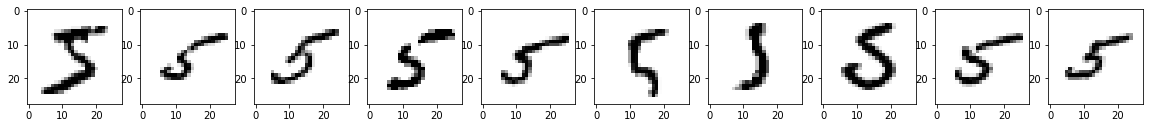

In [8]:
# sample 5 image
fig, axes = plt.subplots(1, 10)
fig.set_figheight(4)
fig.set_figwidth(20)
for i in range(10):
    ax = axes[i]
    ax.imshow(X_train[y_train == 1][i], cmap=plt.get_cmap("gray_r"));

### Sample Negative Targets

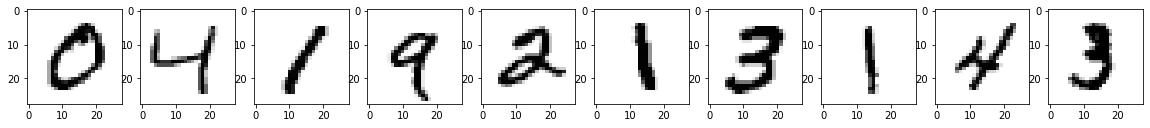

In [9]:
# sample non-5 image
fig, axes = plt.subplots(1, 10)
fig.set_figheight(4)
fig.set_figwidth(20)
for i in range(10):
    ax = axes[i]
    ax.imshow(X_train[y_train == 0][i], cmap=plt.get_cmap("gray_r"));

### Target rate, image size, and mean/std calculation

In [10]:
# target incidence in training set
y_train.to(torch.float32).mean().item()

0.09035000205039978

In [11]:
# image size
X_train[0].shape

torch.Size([28, 28])

In [12]:
# image means and std for normalization
train_mean = X_train.to(torch.float32).mean()
train_std = X_train.to(torch.float32).std()

### CNN Weak Learner - Initial Layer

For the initial boosted layer, let's use a convolutional net, with a single convolution in each linear that downsizes to a 32-unit dense layer before making the final class prediction. Arbitrarily, `tanh` activations are used.

In [13]:
class NetL1(nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.dense2 = nn.Linear(28 * 28, 1)
        
    def forward(self, X):      
        # normalize the inputs with training set image means and std
        out = torchvision.transforms.functional.normalize(X, train_mean, train_std)
        
        # network modules
        out = self.conv1(X)
        out = self.act1(out)
        out = out.view(-1, 28 * 28)
        out = self.dense2(out).flatten()
        return out

That is the learner, now let's wrap it in a class with fit and predict methods.

In [14]:
class NetL1Wrapper:
    """Wrapper for NetL1 class for use in BoostedModel."""
    
    def __init__(self, training_epochs=5, lr=0.01, random_state=0):
        self._model = None   # attribute to store the NN
        self._epochs = training_epochs
        self._lr = lr
        random.seed(random_state)
    
    def fit(self, X, y, weights=None):
        self._model = NetL1()
        self._model.to(device=device)
        self._initialize_weights()
        optimizer = torch.optim.Adam(lr=self._lr, params=self._model.parameters())
        train_loader = torch.utils.data.DataLoader(
            NumpyDataset(X, y),
            batch_size=32,
            shuffle=True,
        )
        example_trainer(
            model=self._model,
            train_loader=train_loader,
            optimizer=optimizer
        )
        
        # set model attribute and return self
        return self
    
    def predict(self, X):
        self._model.to(device="cpu")
        with torch.no_grad():
            Xt = torch.from_numpy(X).to(torch.float32).unsqueeze(1)
            outputs = self._model(Xt).squeeze().numpy()
        return outputs
    
    def _initialize_weights(self):
        with torch.no_grad():
            self._model.apply(self.init_weights)
                
    @staticmethod
    def init_weights(layer):
        if type(layer) != NetL1 and hasattr(layer, "weight"):
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)

### Boost Units that will Build the First Layer

In [15]:
model = BoostedModel(
    link=LogitLink(),
    loss=LogLoss(),
    model_callback=NetL1Wrapper,
    alpha=5.0,
    step_type="best",
    init_type="zero",
    validation_fraction=0.20,
    validation_iter_stop=10,
    validation_stratify=True,
)
model.fit(X_train.numpy(), y_train.to(torch.float32).numpy(), iterations=32);

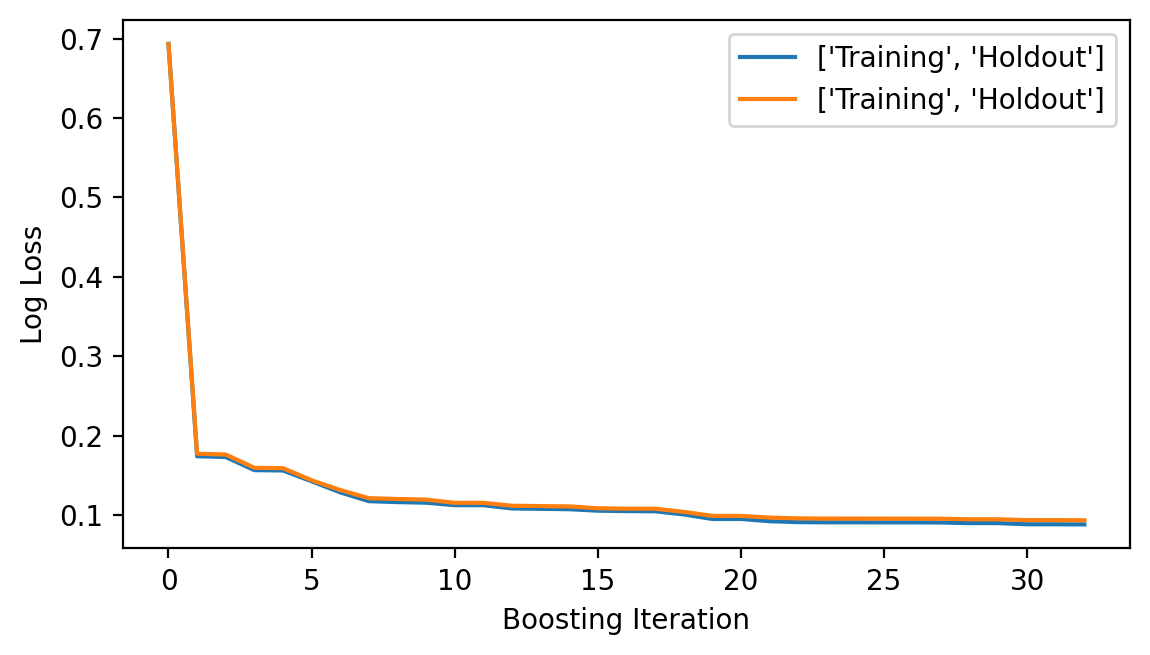

In [16]:
fig = plt.figure(figsize=(6.5, 3.5), dpi=200)
ax = fig.add_subplot(111)
ax.plot(model.get_loss_history(), label=["Training", "Holdout"])
ax.set_ylabel("Log Loss")
ax.set_xlabel("Boosting Iteration")
ax.legend(loc="best");

In [17]:
model.get_iterations()   # number of out channels for the first layer

32

### Build the first layer

Let's build the first layer, a single layer of convolutions, by extracting the boosted convolutional weights from each model iteration. To do this, we will access the "private" `_model_list` attribute of the underlying `BoostedModel` class. This goes against convention - however, access to the individual models will be exposed in version 1.0.

Below, we create a new `pytorch` module that is the same as the boosted model with a few key differences:
* The number of channels to the convolutional layer has been changed to match the number of boosting iterations in the boosted model above; and
* The dense layer and its associated input transformation inside of the module `forward` method have been removed.

After the module class has been created, we will aggregate the weights from the boosted model convolutional layer , set the weights of the new module, and then use the module to create inputs for the next planned network layer.

In [18]:
weights = (
    torch
    .stack([m._model.conv1.weight for m, _ in model._model_list])
    .reshape((-1, 1, 3, 3))
)
bias = torch.stack([m._model.conv1.bias for m, _ in model._model_list]).squeeze()

In [19]:
num_channels_1 = model.get_iterations()

class Module1(nn.Module):    
    def __init__(self, num_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(1, num_channels, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        
    def forward(self, X):
        # normalize the inputs with training set image means and std
        out = torchvision.transforms.functional.normalize(X, train_mean, train_std)
        
        # network modules
        out = self.conv1(X)
        out = self.act1(out)
        return out

In [20]:
# set the weights from our first round of boosting
mod1 = Module1(num_channels_1)
mod1.conv1.weight = torch.nn.Parameter(weights)
mod1.conv1.bias = torch.nn.Parameter(bias)

### Build the second layer

Now let's create the second layer (module) and wrapper for use in `genestboost`. Without questioning, we will build a module to perform a 2x2 max pool (MNIST data has a black background) with stride 2, followed by another 3x3 convolutional layer. We will use `mod1` under a `torch.no_grad` context so that the weights remain static. This allows use to make the same `BoostedModel` call above without having to worry about re-creating inputs at each new layer.

In [21]:
class NetL2(nn.Module):    
    def __init__(self, channels_in):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, 1, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.dense2 = nn.Linear(14 * 14, 1)   # max pooling will cut size in half
        
    def forward(self, X):
        # send the input through our first layer here
        with torch.no_grad():
            if next(self.parameters()).is_cuda:
                mod1.to(device="cuda")
            else:
                mod1.to(device="cpu")
            out = mod1(X)
            
        # perform second layer calculations here
        out = nn.functional.max_pool2d(out, kernel_size=2, stride=2)   # max pooling
        out = self.conv1(out)
        out = self.act1(out)
        out = out.view(-1, 14 * 14)
        out = self.dense2(out).flatten()
        return out

In [22]:
class NetL2Wrapper:
    """Wrapper for NetL2 for use in the BoostedModel class."""
    
    def __init__(self, channels_in, training_epochs=5, lr=0.01, random_state=0):
        self._channels_in = channels_in
        self._model = None   # attribute to store the NN
        self._epochs = training_epochs
        self._lr = lr
        random.seed(random_state)
    
    def fit(self, X, y, weights=None):
        self._model = NetL2(self._channels_in)
        self._model.to(device=device)
        self._initialize_weights()
        optimizer = torch.optim.Adam(lr=self._lr, params=self._model.parameters())
        train_loader = torch.utils.data.DataLoader(
            NumpyDataset(X, y),
            batch_size=32,
            shuffle=True,
        )
        example_trainer(
            model=self._model,
            train_loader=train_loader,
            optimizer=optimizer
        )
        
        # set model attribute and return self
        return self
    
    def predict(self, X):
        self._model.to(device="cpu")
        with torch.no_grad():
            Xt = torch.from_numpy(X).to(torch.float32).unsqueeze(1)
            outputs = self._model(Xt).squeeze().numpy()
        return outputs
    
    def _initialize_weights(self):
        with torch.no_grad():
            self._model.apply(self.init_weights)
                
    @staticmethod
    def init_weights(layer):
        if type(layer) != NetL2 and hasattr(layer, "weight"):
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.0)

In [23]:
model = BoostedModel(
    link=LogitLink(),
    loss=LogLoss(),
    model_callback=NetL2Wrapper,
    model_callback_kwargs={"channels_in": num_channels_1},
    alpha=5.0,
    step_type="best",
    init_type="zero",
    validation_fraction=0.20,
    validation_iter_stop=10,
    validation_stratify=True,
)
model.fit(X_train.numpy(), y_train.numpy(), iterations=32);

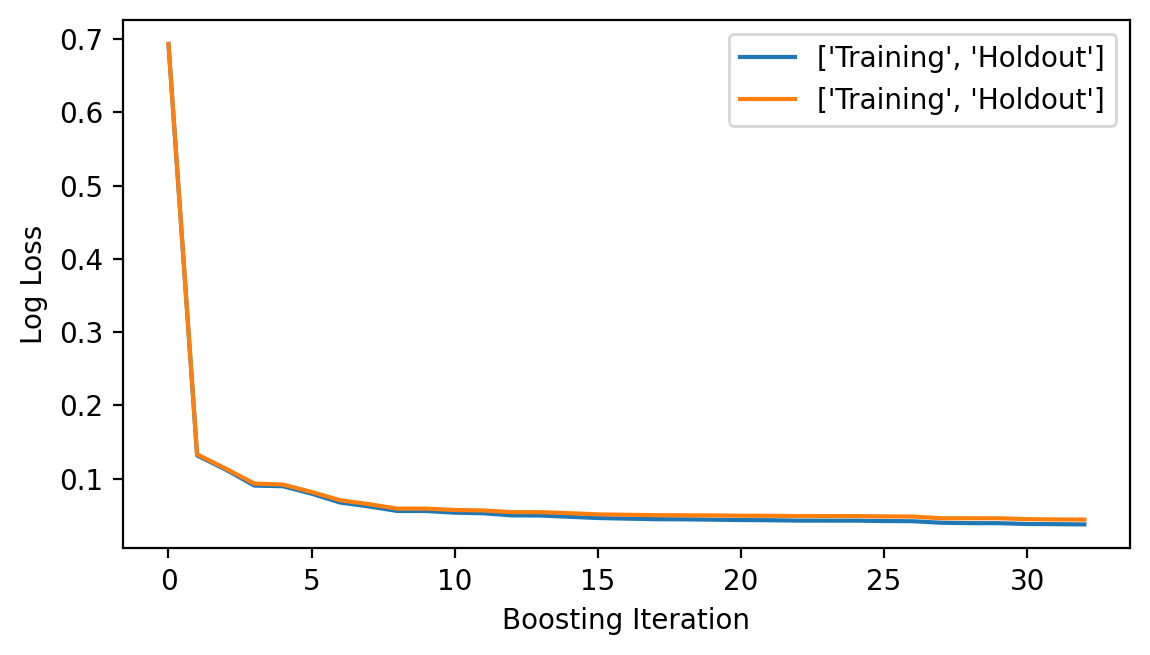

In [24]:
fig = plt.figure(figsize=(6.5, 3.5), dpi=200)
ax = fig.add_subplot(111)
ax.plot(model.get_loss_history(), label=["Training", "Holdout"])
ax.set_ylabel("Log Loss")
ax.set_xlabel("Boosting Iteration")
ax.legend(loc="best");

In [25]:
model.get_iterations()

32

Below, we once again will store the weights from the second layer and create a second module. The second module will give us the output from the first two layers and will be used internally in building layer three to get inputs so that once gain, we can make the same call to `BoostedModel`, only having to change the `model_callback` and `model_callback_kwargs`.

In [26]:
weights = (
    torch
    .stack([m._model.conv1.weight for m, _ in model._model_list])
    .reshape((-1, 32, 3, 3))
)
bias = torch.stack([m._model.conv1.bias for m, _ in model._model_list]).squeeze()

In [27]:
num_channels_2 = model.get_iterations()

In [28]:
class Module2(nn.Module):    
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        
    def forward(self, X):
        # send the input through our first layer here
        with torch.no_grad():
            if next(self.parameters()).is_cuda:
                mod1.to(device="cuda")
            else:
                mod1.to(device="cpu")
            out = mod1(X)
            
        # perform second layer calculations here
        out = nn.functional.max_pool2d(out, kernel_size=2, stride=2)   # max pooling
        out = self.conv1(out)
        out = self.act1(out)
        return out

In [29]:
# set the weights from our first round of boosting
mod2 = Module2(num_channels_1, num_channels_2)
mod2.conv1.weight = torch.nn.Parameter(weights)
mod2.conv1.bias = torch.nn.Parameter(bias)

### Build the final, dense layer

Repeat the above process for the final dense layer.

In [30]:
class NetL3(nn.Module):    
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(32 * 14 * 14, 1)
        
    def forward(self, X):
        # send the input through our first two layers (mod1 and mod2) here
        # remember that mod2 contains mod1
        with torch.no_grad():
            if next(self.parameters()).is_cuda:
                mod2.to(device="cuda")
            else:
                mod2.to(device="cpu")
            out = mod2(X)   # remember that mod2 contains mod1
            
        # perform third layer calculations here
        out = out.view(-1, 14 * 14 * 32)
        out = self.dense1(out).flatten()
        return out

In [31]:
class NetL3Wrapper:    
    def __init__(self, training_epochs=5, lr=0.01, random_state=0):
        self._model = None   # attribute to store the NN
        self._epochs = training_epochs
        self._lr = lr
        random.seed(random_state)
    
    def fit(self, X, y, weights=None):
        self._model = NetL3()
        self._model.to(device=device)
        self._initialize_weights()
        optimizer = torch.optim.Adam(lr=self._lr, params=self._model.parameters())
        train_loader = torch.utils.data.DataLoader(
            NumpyDataset(X, y),
            batch_size=32,
            shuffle=True,
        )
        example_trainer(
            model=self._model,
            train_loader=train_loader,
            optimizer=optimizer
        )
        
        # set model attribute and return self
        return self
    
    def predict(self, X):
        self._model.to(device="cpu")
        with torch.no_grad():
            Xt = torch.from_numpy(X).to(torch.float32).unsqueeze(1)
            outputs = self._model(Xt).squeeze().numpy()
        return outputs
    
    def _initialize_weights(self):
        with torch.no_grad():
            self._model.apply(self.init_weights)
                
    @staticmethod
    def init_weights(layer):
        if type(layer) != NetL3 and hasattr(layer, "weight"):
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.0)

In [32]:
model = BoostedModel(
    link=LogitLink(),
    loss=LogLoss(),
    model_callback=NetL3Wrapper,
    model_callback_kwargs={},
    alpha=5.0,
    step_type="best",
    init_type="zero",
    validation_fraction=0.20,
    validation_iter_stop=10,
    validation_stratify=True,
)
model.fit(X_train.numpy(), y_train.numpy(), iterations=16);

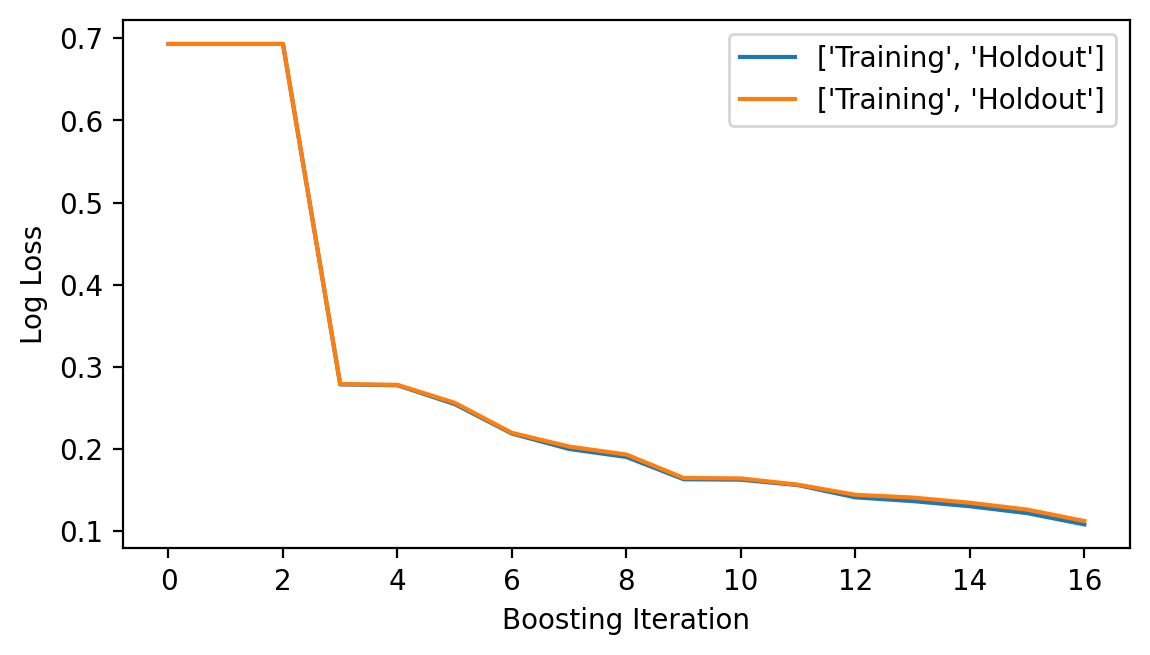

In [33]:
fig = plt.figure(figsize=(6.5, 3.5), dpi=200)
ax = fig.add_subplot(111)
ax.plot(model.get_loss_history(), label=["Training", "Holdout"])
ax.set_ylabel("Log Loss")
ax.set_xlabel("Boosting Iteration")
ax.legend(loc="best");

### Putting it all together in a single network

We could use the last prediction as is - a boosted ensemble of convolutional neural networks that was trained one convolutional layer at a time. Just for fun, though, let's build a final model that is a single neural network.

To do this, we first create module three, a `pytorch` network of our layers thus far, then optimize the final output using `pytorch`. Since we are using `pytorch` directly here, the final dense output layer will be trained as a classifier with two outputs. `CrossEntropyLoss` will be used - this will automatically log-softmax the two outputs in the loss calculation. Note that this needs to be done manually on the final predictions if the intent is to convert to probabilities.

In [34]:
weights = (
    torch
    .stack([m._model.dense1.weight for m, _ in model._model_list])
    .squeeze(1)
)
bias = torch.stack([m._model.dense1.bias for m, _ in model._model_list]).squeeze()

In [35]:
class Module3(nn.Module):
    """Module3 - note the 16 channels out corresponding to the boosting iterations above."""
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(32 * 14 * 14, 16)
        
    def forward(self, X):
        # send the input through our first two layers (mod1 and mod2) here
        # remember that mod2 contains mod1
        with torch.no_grad():
            if next(self.parameters()).is_cuda:
                mod2.to(device="cuda")
            else:
                mod2.to(device="cpu")
            out = mod2(X)
            
        # perform third layer calculations here
        out = out.view(-1, 14 * 14 * 32)
        out = self.dense1(out)
        return out

In [36]:
# set the weights from our first round of boosting
mod3 = Module3()
mod3.dense1.weight = torch.nn.Parameter(weights)
mod3.dense1.bias = torch.nn.Parameter(bias)

In [37]:
class FinalNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(16, 2)   # output for each class
        
    def forward(self, X):
        with torch.no_grad():
            if next(self.parameters()).is_cuda:
                mod3.to(device="cuda")
            else:
                mod3.to(device="cpu")
            out = mod3(X)   # remember that mod2 contains mod1
        out = self.dense1(out)
        return out   

In [38]:
# create and train the model for an epoch
final_model = FinalNet()
final_model.to(device=device)
train_loader = torch.utils.data.DataLoader(
    NumpyDataset(X_train.numpy(), y_train.numpy(), target_type=torch.long),
    batch_size=32,
    shuffle=True,
)
training_loop(
    n_epochs=1,
    optimizer=torch.optim.Adam(lr=0.01, params=final_model.parameters()),
    model=final_model,
    loss_fn=nn.CrossEntropyLoss(),
    train_loader=train_loader
)
final_model.to(device="cpu")

FinalNet(
  (dense1): Linear(in_features=16, out_features=2, bias=True)
)

### Evaluate Train and Test Error

In [39]:
final_model.eval()   # set model in eval mode
train_preds = final_model(X_train.to(torch.float32).unsqueeze(1))
train_preds = nn.functional.softmax(train_preds, dim=1)[:, 1].detach().numpy()
test_preds = final_model(X_test.to(torch.float32).unsqueeze(1))
test_preds = nn.functional.softmax(test_preds, dim=1)[:, 1].detach().numpy()

In [40]:
train_roc = roc_auc_score(y_train.numpy(), train_preds)
train_accuracy = np.sum((y_train.numpy() == 1) == (train_preds > 0.5)) / train_preds.shape[0]
test_roc = roc_auc_score(y_test.numpy(), test_preds)
test_accuracy = np.sum((y_test.numpy() == 1) == (test_preds > 0.5)) / test_preds.shape[0]

In [41]:
print("Training set:")
print("    ROCAUC: {:.3f}".format(train_roc))
print("  Accuracy: {:.3f}".format(train_accuracy))
print()
print("Test set:")
print("    ROCAUC: {:.3f}".format(test_roc))
print("  Accuracy: {:.3f}".format(test_accuracy))

Training set:
    ROCAUC: 0.993
  Accuracy: 0.985

Test set:
    ROCAUC: 0.991
  Accuracy: 0.986
